In [195]:
import os
import toml
import multiprocessing as mp
from functools import reduce, partial

import pandas as pd
import scipy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from pandas.plotting import lag_plot, autocorrelation_plot, bootstrap_plot, radviz

import copy
import gc

import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.decomposition import PCA
from sklearn import preprocessing

from typing import List, Dict, NoReturn, Any, Callable, Union, Optional

from preproc import import_csv, new_hybrid_interpolator
from customobjs import objdict

In [20]:
def dist_plot(series: pd.core.series.Series, dropna: bool = True, sig: Optional[int] = None) -> NoReturn:
    """
        Given a pandas Series, generate a descriptive visualisation 
        with a boxplot and a histogram with a kde.
        By default, this function drops `nan` values. If you desire to
        handle them differently, you should do so beforehand and/or
        specify dropna=False.
    """
    
    if dropna:
        series = series.dropna()
    sig = sig or 0
    
    
    quarts = scipy.stats.mstats.mquantiles(series, [0.001, 0.25, 0.5, 0.75, 0.975])
    
    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.25, .75)})
    sns.boxplot(series, ax=ax_box)
    sns.stripplot(series, color="orange", jitter=0.2, size=2.5, ax=ax_box)
    sns.distplot(series, ax=ax_hist, kde=True)
    ax_hist.axvline(series.mean())
    ax_hist.set_xticks(quarts)
    #ax_box.set(xlabel=f'Mean value : {int(series.mean())}')
    plt.title(f"Glycaemic Distribution μ = {round(series.mean(), sig)}, σ = {round(series.std(), sig)}")
##

def comparative_hba1c_plot(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    hba1c: Callable = lambda x: (x + 105) / 36.5,
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "mean"
) -> NoReturn:
    """ 
    """
    
    glc_to_hba1c = lambda x: (x + 105) / 36.5
    hba1c_to_glc = lambda x: x*36.5 - 105 
    valid_kinds = ["mean", "std", "var", "median"]
    
    if kind in valid_kinds:
        df.groupby(df.index.date)[colum_name].\
            apply(eval(f"pd.Series.{kind}")).apply(hba1c).\
                plot(**{"label":"daily"})
                
        for key, value in windows.items():
            ax = df.groupby(df.index.date)[colum_name].\
                    apply(eval(f"pd.Series.{kind}")).rolling(value).mean().\
                            apply(hba1c).plot(**{"label":key})
    
        ax.set_ylabel("HbA1c %")
        mean_hba1c = glc_to_hba1c(eval(f"df[colum_name].{kind}()"))
        secax = ax.secondary_yaxis('right', functions=(hba1c_to_glc, glc_to_hba1c))
        secax.set_ylabel('mg/dL')
        plt.axhline(mean_hba1c, **{"label": f"mean = {round(mean_hba1c,1)}", "c": "blue"})
        plt.legend()
        plt.title(f"Average {kind} of {colum_name}")
    else:
        raise Exception(f"kind should be one of {valid_kinds}")
##

def proportions_visualiser(
    df: pd.core.frame.DataFrame,
    colum_name: str = "Sensor Glucose (mg/dL)",
    limits: Dict[str,int] = {
        "low": 70,
        "high": 180
    },
    windows: Dict[str,int] = {
        "weekly": 7,
        "monthly": 30
    },
    kind: str = "TIR"
) -> NoReturn:
    """
        Wuhuuuu
    """
    
    valid_kinds = ["TIR", "TBR", "TAR"]
    titles = {
        "TIR": f"Time In Range [{limits['low']},{limits['high']})",
        "TAR": f"Time Above Range >= {limits['high']}",
        "TBR": f"Time Below Range < {limits['low']}"
    }
    
    kind = kind.upper()
    
    if kind not in valid_kinds:
        raise Exception(f"Invalid kind `{kind}`, select one from {valid_kinds}")
    
    TIR = lambda y: 100 * y[ (y >= limits["low"]) & (y < limits["high"]) ].count() / y.count()
    TBR = lambda y: 100 * y[ (y < limits["low"]) ].count() / y.count()
    TAR = lambda y: 100 * y[ (y >= limits["high"]) ].count() / y.count()
    
    _proportions = df["Sensor Glucose (mg/dL)"].groupby(data.index.date).apply(eval(f"{kind}"))
    
    _proportions.plot(**{"label": "daily"})
    
    for key, value in windows.items():
        _ax = _proportions.rolling(value).mean().plot(**{"label":key})
    
    _mean_proportion = _proportions.mean()
    plt.ylabel("Percentage")
    plt.axhline(_mean_proportion, **{"label": f"mean = {round(_mean_proportion,1)}", "c": "blue"})
    plt.legend()
    plt.title(titles[kind])
##    

def nonull_indices(
    df: pd.DataFrame,
    column: str
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """  
    _nonull = df[column].dropna()
    _nonull = _nonull[ _nonull > 0 ]
    return _nonull.index
##

def bolus_indices(
    df: pd.DataFrame, 
    columns: Optional[List[str]] = None
) -> pd.core.indexes.datetimes.DatetimeIndex:
    """
    """
    
    columns = columns or ["BWZ Correction Estimate (U)",  "BWZ Carb Input (grams)"]
    _nonull = partial(nonull_indices, df)
    indices_ls = list(map(_nonull, columns))
    return reduce(lambda x, y: x.union(y), indices_ls)
##


def basal_only(df: pd.DataFrame, column: str = "Sensor Glucose (mg/dL)") -> pd.DataFrame:
    """
    """
    basal = df.copy()
    for uid in bolus_indices(basal):
        real = uid+dt.timedelta(hours=2, minutes=30)
        closest = df.index[df.index.searchsorted(real) - 1]  # Otherwise it goes out of bounds !
        basal.loc[uid:closest, column] = np.nan
    return basal
##

def hourly_trends(df: pd.DataFrame, kind: str = "mean", deltas: Optional[List[int]] = None) -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var", "median"]
    deltas = deltas or [15, 30, 60, 120]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}']\
                .apply(eval(f"np.{kind}"))\
                    .plot(label=f"{i} ") 
            for i in deltas
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##        

In [ ]:
def hourly_trends(df: pd.DataFrame, kind: str = "mean", deltas: Optional[List[int]] = None) -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var", "median"]
    deltas = deltas or [15, 30, 60, 120]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}']\
                .apply(eval(f"np.{kind}"))\
                    .plot(label=f"{i} ") 
            for i in deltas
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##   

In [26]:
def compute_time_periodicity(df: pd.DataFrame) -> NoReturn:
    """
    """
    # Coulmns to capture daily periodicity :
    T = 1439
    min_res_t_series = pd.Series(df.index.hour*60 + df.index.minute)
    _tmp = pd.DataFrame({
        'hour': df.index.hour,
        'minute': min_res_t_series,
        'x(t)': min_res_t_series.apply(lambda x: np.cos(2*np.pi*x / T)),
        'y(t)': min_res_t_series.apply(lambda x: np.sin(2*np.pi*x / T))
    })
    _tmp.index = df.index
    return _tmp
##

In [68]:
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 8)

In [69]:
!ls interpolated/ | grep 20-06

NG1988812H_Maganna_Gustavo_(24-05-20)_(20-06-20)_interpolated.csv
NG1988812H_Maganna_Gustavo_(29-03-20)_(20-06-20)_interpolated.csv
NG1988812H_Maganna_Gustavo_(7-06-20)_(20-06-20)_interpolated.csv


In [201]:
data = import_csv("interpolated/NG1988812H_Maganna_Gustavo_(29-03-20)_(20-06-20)_interpolated.csv")

/Users/gml/Library/Caches/pypoetry/virtualenvs/diabetes-analysis--6n-IUK1-py3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1,6,7,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [71]:
#pd.read_csv

In [72]:
#data.columns

In [250]:
my_columns = [
    'BG Reading (mg/dL)', 'Basal Rate (U/h)', 'Temp Basal Amount', 
    'Temp Basal Type', 'Temp Basal Duration (h:mm:ss)', 'Bolus Volume Delivered (U)',
    'BWZ Active Insulin (U)', 'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)', 
    'ISIG Value', 'hour', 'minute', 'x(t)', 'y(t)'
]
data = data[my_columns]
deltas = [1, 5, 15, 30, 60, 120]
woo = pd.DataFrame()
for i in deltas:
    woo[f"Dg{i}"] = data["Sensor Glucose (mg/dL)"].diff(i)
    woo[f"D2g{i}"] = woo[f"Dg{i}"].diff(1)
data = data.join(woo)

In [205]:
data.head()

,BG Reading (mg/dL),Basal Rate (U/h),Temp Basal Amount,Temp Basal Type,Temp Basal Duration (h:mm:ss),Bolus Volume Delivered (U),BWZ Active Insulin (U),Sensor Calibration BG (mg/dL),Sensor Glucose (mg/dL),ISIG Value,...,Dg5,D2g5,Dg15,D2g15,Dg30,D2g30,Dg60,D2g60,Dg120,D2g120
DateTime,,,,,,,,,,,,,,,,,,,,,
2020-03-26 21:17:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.000000,29.55,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26 21:18:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.135821,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26 21:19:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,160.309731,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26 21:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,159.515731,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-26 21:21:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.747821,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [206]:
data.columns

Index(['BG Reading (mg/dL)', 'Basal Rate (U/h)', 'Temp Basal Amount',
       'Temp Basal Type', 'Temp Basal Duration (h:mm:ss)',
       'Bolus Volume Delivered (U)', 'BWZ Active Insulin (U)',
       'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)', 'ISIG Value',
       'hour', 'minute', 'x(t)', 'y(t)', 'Dg1', 'D2g1', 'Dg5', 'D2g5', 'Dg15',
       'D2g15', 'Dg30', 'D2g30', 'Dg60', 'D2g60', 'Dg120', 'D2g120'],
      dtype='object')

In [207]:
def hourly_trends(df: pd.DataFrame, kind: str = "mean", deltas: Optional[List[int]] = None) -> NoReturn:
    """
    """
    valid_kinds = ["mean", "std", "var", "median"]
    deltas = deltas or [15, 30, 60, 120]
    
    if kind in valid_kinds:
        figs = [
            df.groupby(df.index.hour)[f'd{i}']\
                .apply(eval(f"np.{kind}"))\
                    .plot(label=f"{i} ") 
            for i in deltas
        ]
        figs[-1].legend()
        plt.title(f"Hourly trends : {kind}")
        plt.xticks([i for i in range(24)])
        plt.ylabel("mg/dl")
    else:
        raise Exception(f"Invalid kind, select one from {valid_kinds}")
##   

In [208]:
data["Sensor Glucose (mg/dL)"].dropna().shape, data.shape

((116684,), (123965, 26))

In [209]:
# sns.distplot(woo.d30)

In [210]:
print("start \t:", data.index[0])
print("end \t:", data.index[-1])

start 	: 2020-03-26 21:17:00
end 	: 2020-06-20 23:21:00


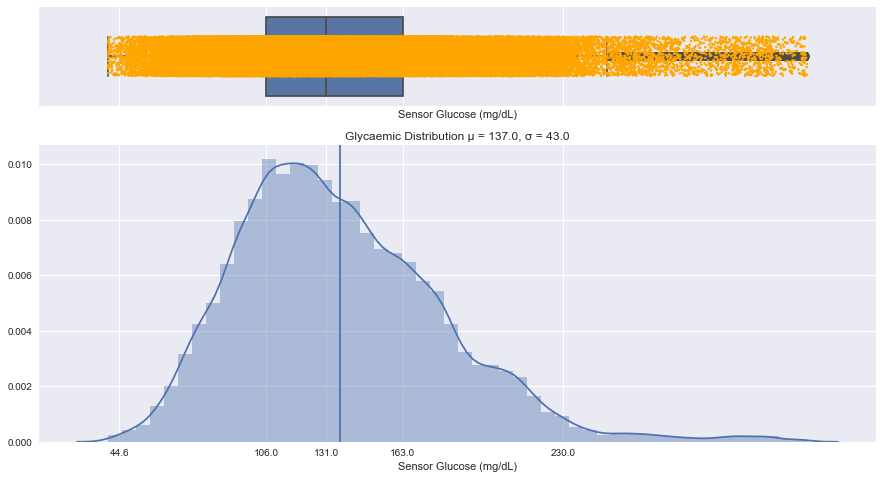

In [211]:
dist_plot(data["Sensor Glucose (mg/dL)"])

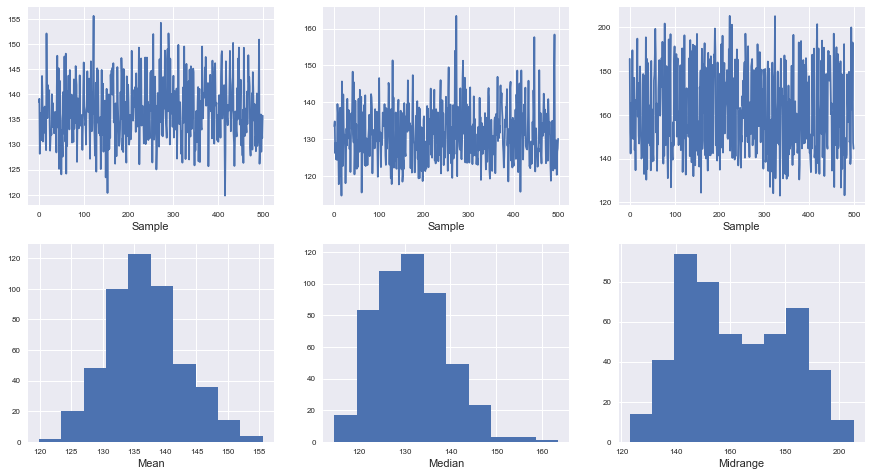

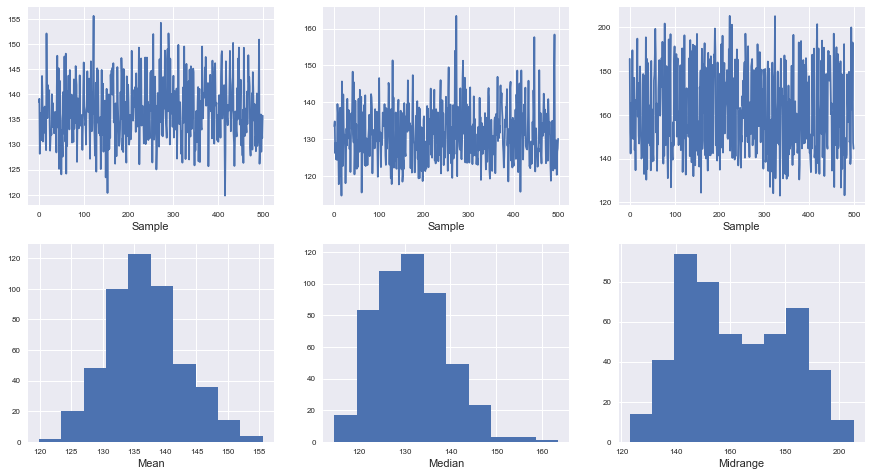

In [212]:
bootstrap_plot(data["Sensor Glucose (mg/dL)"].dropna())

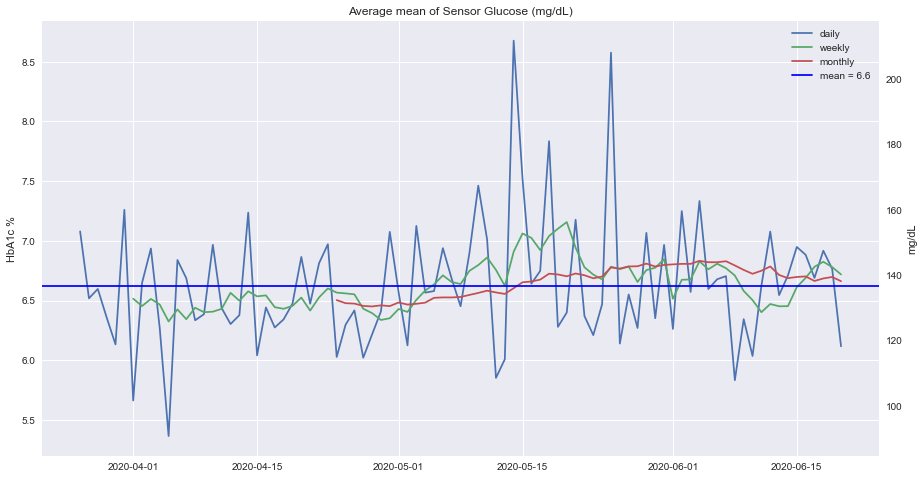

In [214]:
comparative_hba1c_plot(data, kind="mean")

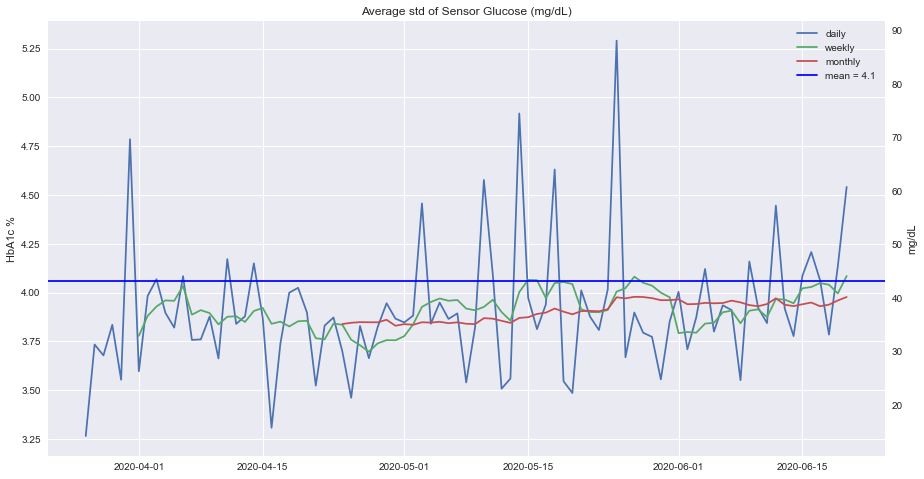

In [215]:
comparative_hba1c_plot(data, kind='std')

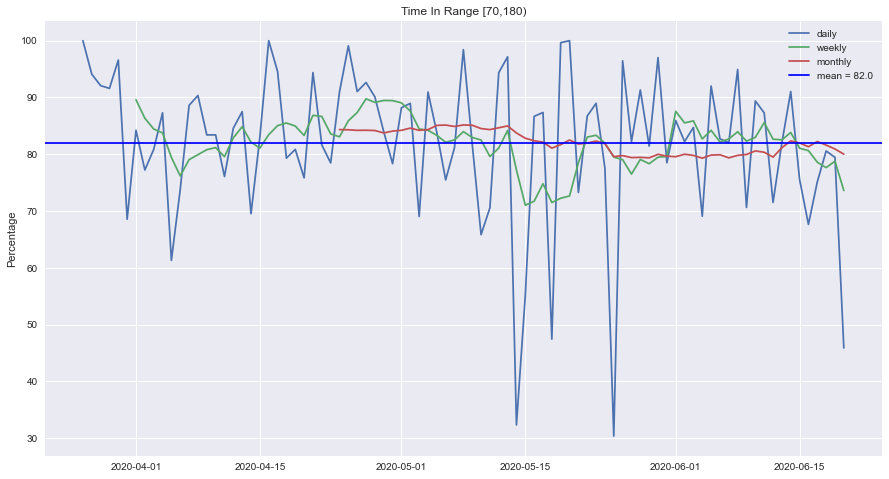

In [216]:
proportions_visualiser(data, kind="tir")

In [217]:
dates = pd.unique(data.index.date)
n_total = len(dates)
print(f"Number of days in data : {len(dates)}")

Number of days in data : 87


In [218]:
n_month = 30
n_latest = 4
#month = data.loc[dates[len(dates) - n_month]:dates[-1], :] if n_month < n_total else None
latest = data.loc[dates[len(dates)- n_latest]:dates[-1], :] if n_latest < n_total else None
lday = data.loc[dates[len(dates)- 1]:dates[-1], :] if n_latest < n_total else None

In [219]:
latest.columns

Index(['BG Reading (mg/dL)', 'Basal Rate (U/h)', 'Temp Basal Amount',
       'Temp Basal Type', 'Temp Basal Duration (h:mm:ss)',
       'Bolus Volume Delivered (U)', 'BWZ Active Insulin (U)',
       'Sensor Calibration BG (mg/dL)', 'Sensor Glucose (mg/dL)', 'ISIG Value',
       'hour', 'minute', 'x(t)', 'y(t)', 'Dg1', 'D2g1', 'Dg5', 'D2g5', 'Dg15',
       'D2g15', 'Dg30', 'D2g30', 'Dg60', 'D2g60', 'Dg120', 'D2g120'],
      dtype='object')

In [220]:
#latest.groupby(latest.index.date).plot()

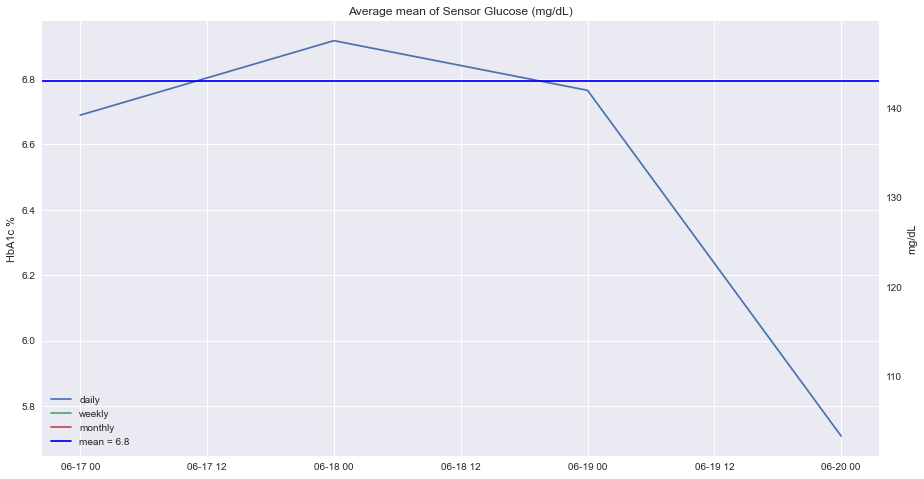

In [221]:
#comparative_hba1c_plot(month)
plt.figure()
comparative_hba1c_plot(latest)

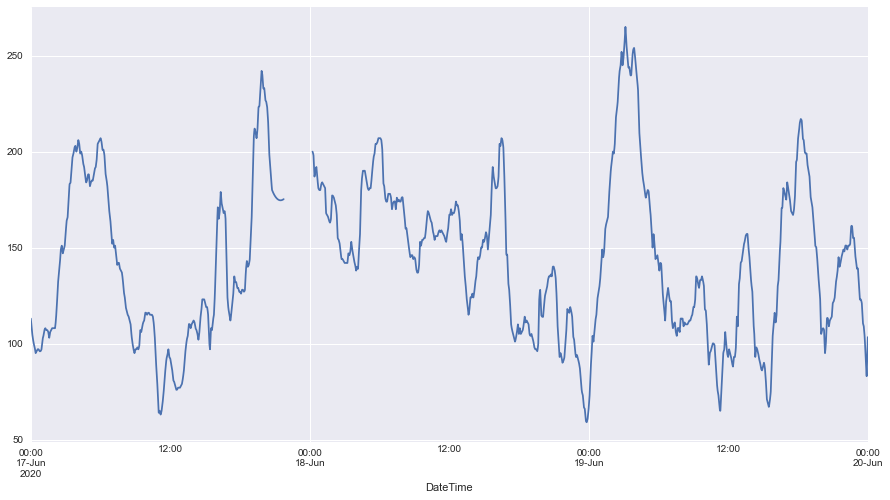

In [222]:
# maybe we should interpolate grouping by day ?
latest["Sensor Glucose (mg/dL)"].plot()

In [254]:
len(grouped)

24

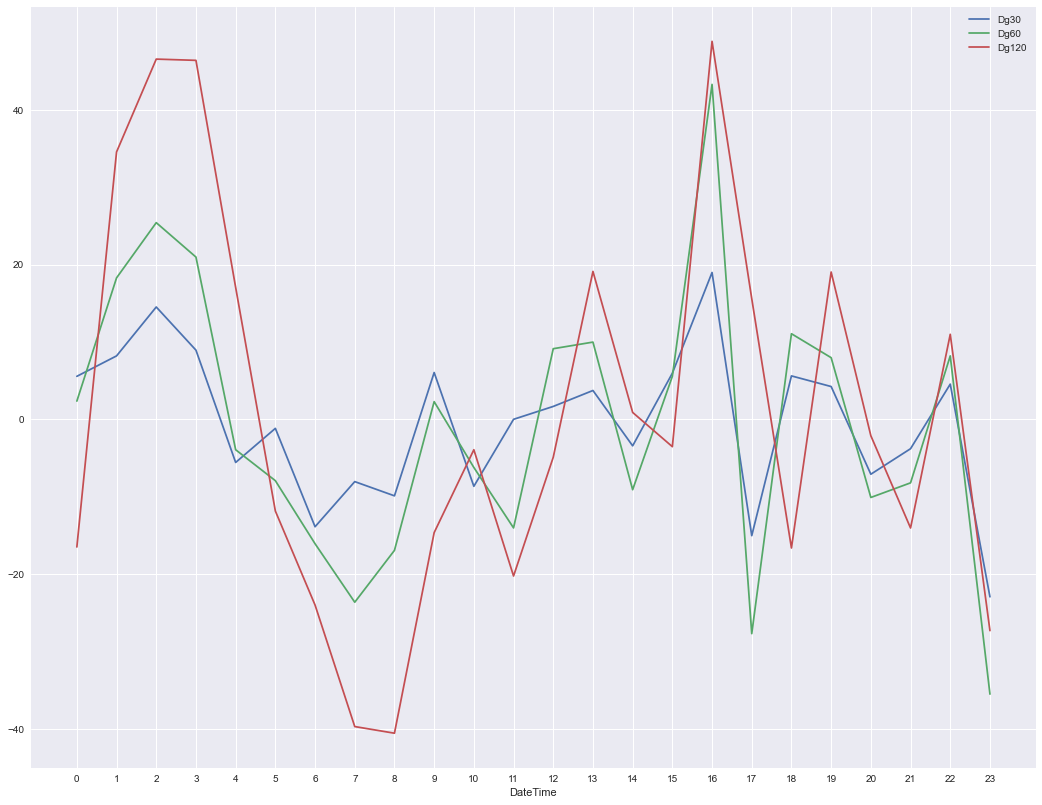

In [257]:
grouped = latest.groupby(latest.index.hour)[[
    "Dg30", "Dg60", "Dg120"
]]

mean = grouped.mean()
std = grouped.std() / len(grouped)**0.5

mean.plot(
    xticks=range(24),
    figsize=(18,14)
)

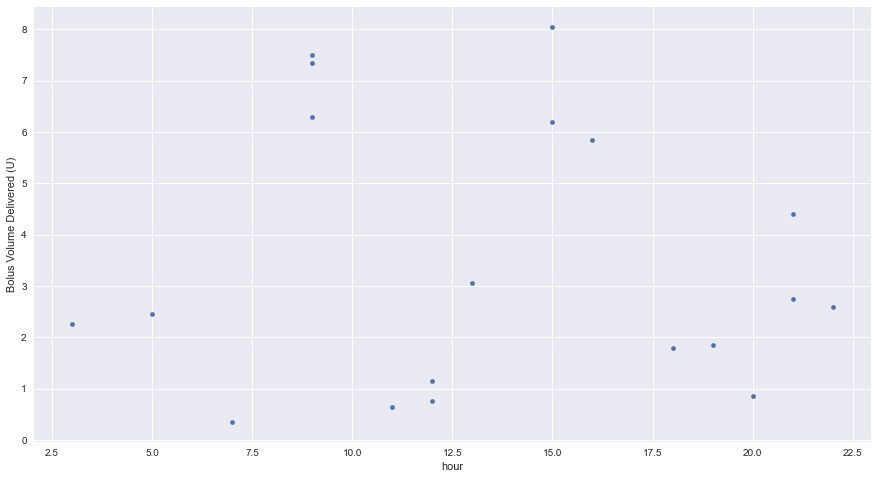

In [263]:
latest.plot(x="hour", y="Bolus Volume Delivered (U)", kind="scatter")

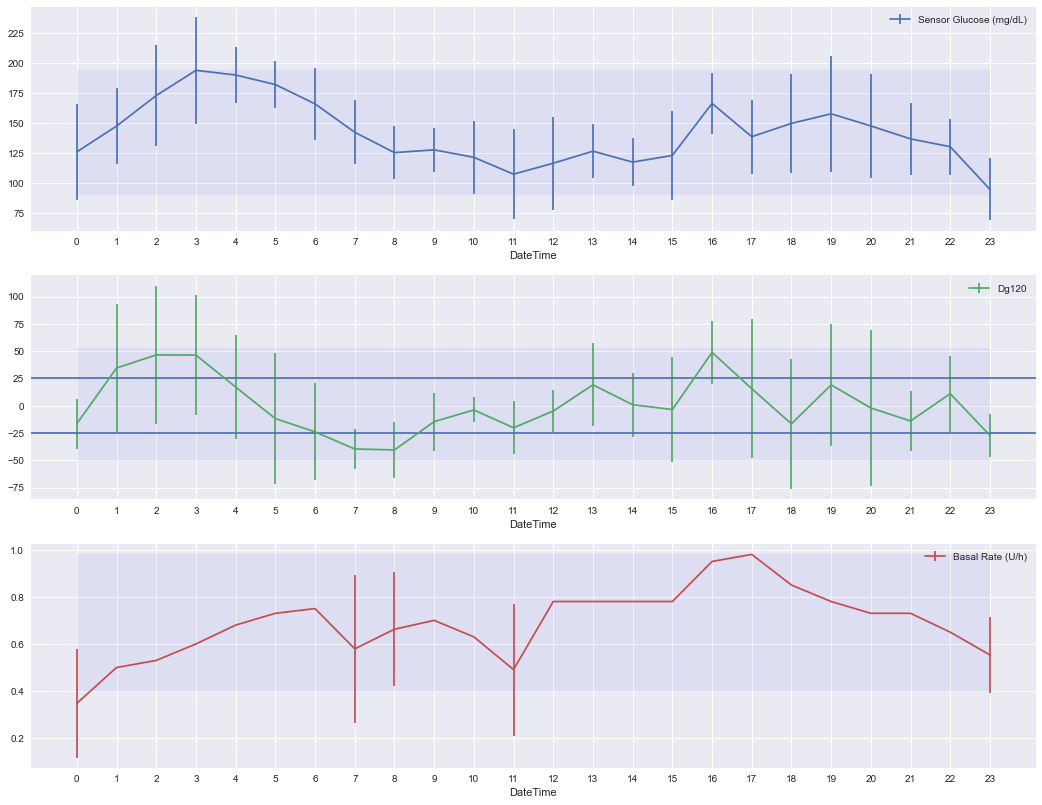

In [275]:
grouped = latest.groupby(latest.index.hour)[[
    "Sensor Glucose (mg/dL)", "Dg120", "Basal Rate (U/h)"
]]

mean = grouped.mean()
std = grouped.std()

ax = mean.plot(
    yerr=std,
    xticks=range(24),
    subplots=True,
    figsize=(18,14),
    sharex=False
)
#ax[1].axhline()
for i, column in enumerate(mean):
    ma, mstd = mean[column].mean(), mean[column].std()
    ax[i].fill_between(range(24), ma - 2 * mstd, ma + 2 * mstd, color='b', alpha=0.05)
    
ax[1].axhline(-25)
ax[1].axhline(25)

In [269]:
for i in mean:
    print(i)

Sensor Glucose (mg/dL)
Dg120
Basal Rate (U/h)


In [268]:
mean["Dg120"].mean()

0.7999558426805713

In [194]:
price = latest["Sensor Glucose (mg/dL)"]
ma = price.rolling(20).mean()
mstd = price.rolling(20).std()
plt.figure()
plt.plot(price.index, price, 'k')
plt.plot(ma.index, ma, 'b')
plt.fill_between(mstd.index, ma - 2 * mstd, ma + 2 * mstd, color='b', alpha=0.2)

AttributeError: 'SeriesGroupBy' object has no attribute 'index'

<Figure size 1080x576 with 0 Axes>

Sensor Glucose (mg/dL)       AxesSubplot(0.125,0.125;0.227941x0.755)
Dg60                      AxesSubplot(0.398529,0.125;0.227941x0.755)
Basal Rate (U/h)          AxesSubplot(0.672059,0.125;0.227941x0.755)
dtype: object

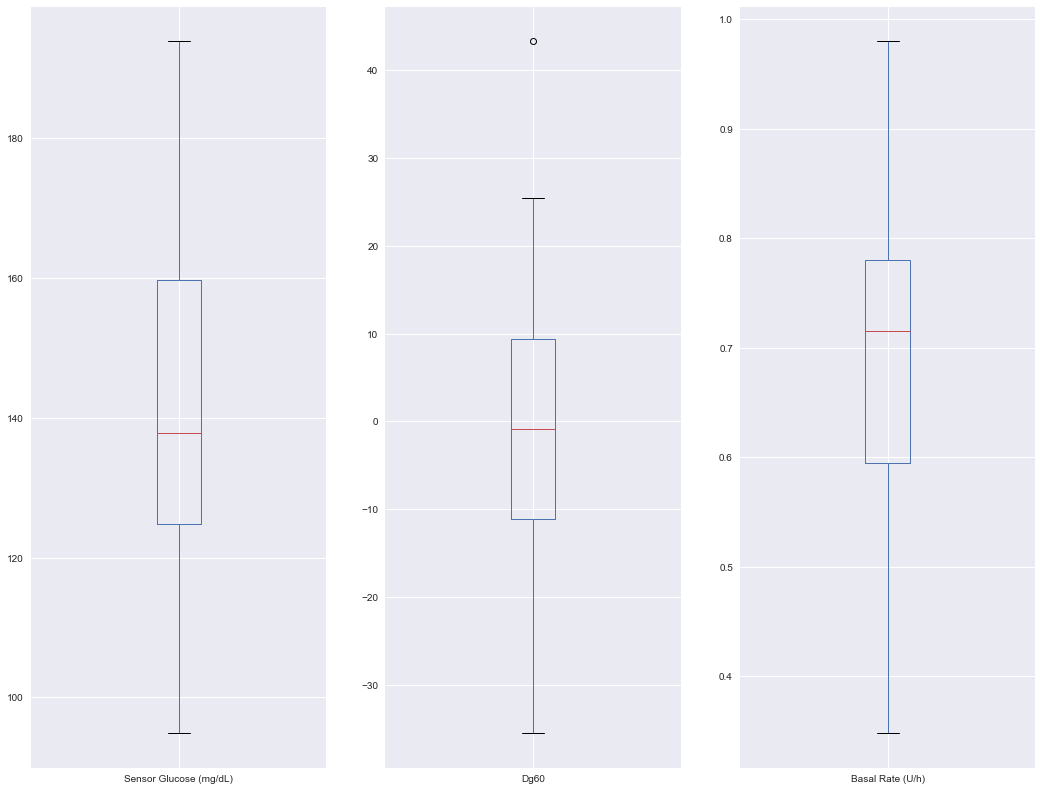

In [186]:
latest.groupby(latest.index.hour)[[
    "Sensor Glucose (mg/dL)", "Dg60", "Basal Rate (U/h)"
]].apply(pd.Series.mean).plot(
    kind="box",
    subplots=True,
    figsize=(18,14)
)

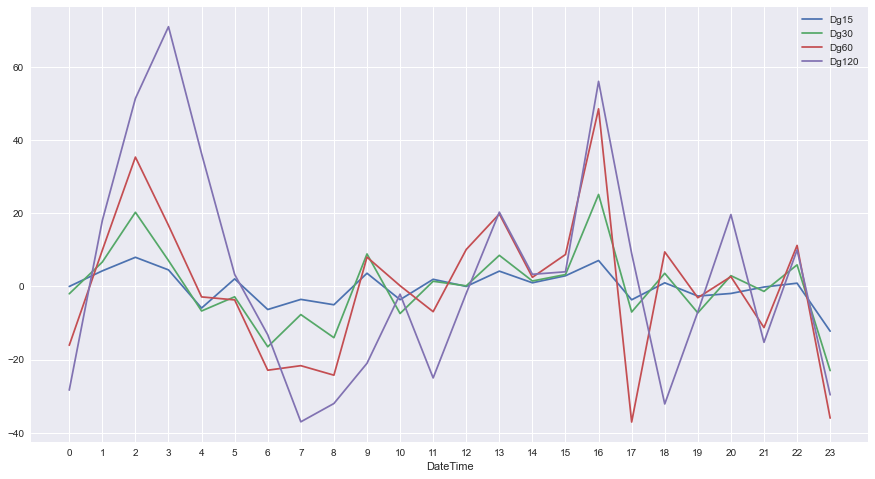

In [103]:
latest[["Dg15", "Dg30", "Dg60", "Dg120"]]\
    .groupby(latest.index.hour)\
        .apply(pd.Series.median)\
            .plot(xticks=range(24))

In [243]:
select = latest["Sensor Glucose (mg/dL)"].dropna()

In [249]:
plt.close("all")
#select.groupby(select.index.hour).plot(kind="box")

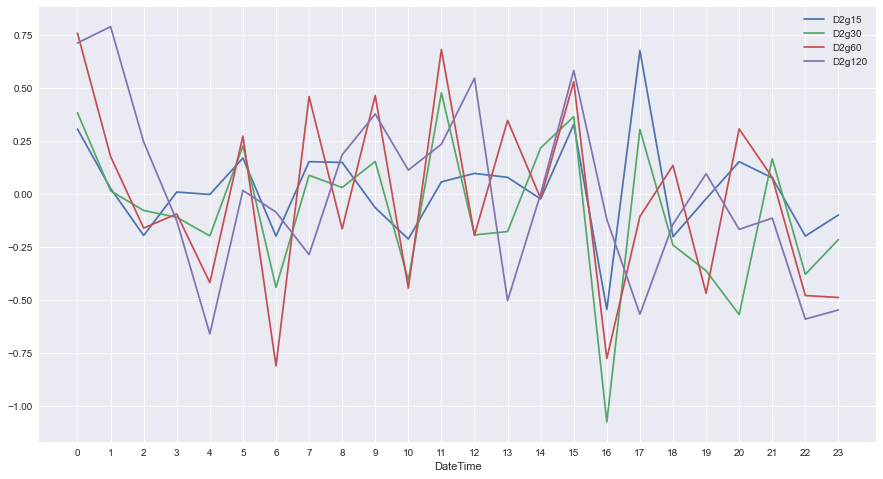

In [105]:
latest[["D2g15", "D2g30", "D2g60", "D2g120"]]\
    .groupby(latest.index.hour)\
        .apply(pd.Series.median)\
            .plot(xticks=range(24))

In [108]:
#latest["Sensor Glucose (mg/dL)"]
#help(pd.Series.autocorr)

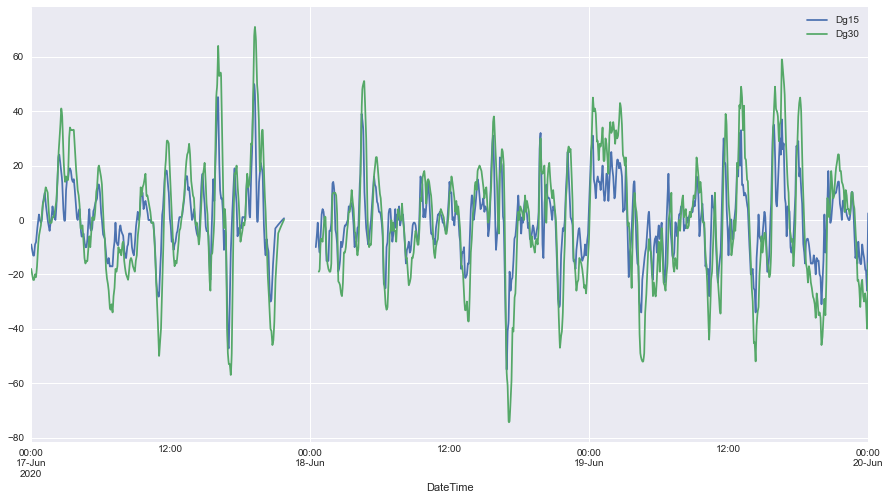

In [95]:
latest[["Dg15", "Dg30"]].groubpy.plot()

In [198]:
"""
sns.scatterplot(
    data=latest,
    x="minutes",
    y="Sensor Glucose (mg/dL)",
    hue=latest.index.date,
    size="d30"
)
"""

'\nsns.scatterplot(\n    data=latest,\n    x="minutes",\n    y="Sensor Glucose (mg/dL)",\n    hue=latest.index.date,\n    size="d30"\n)\n'

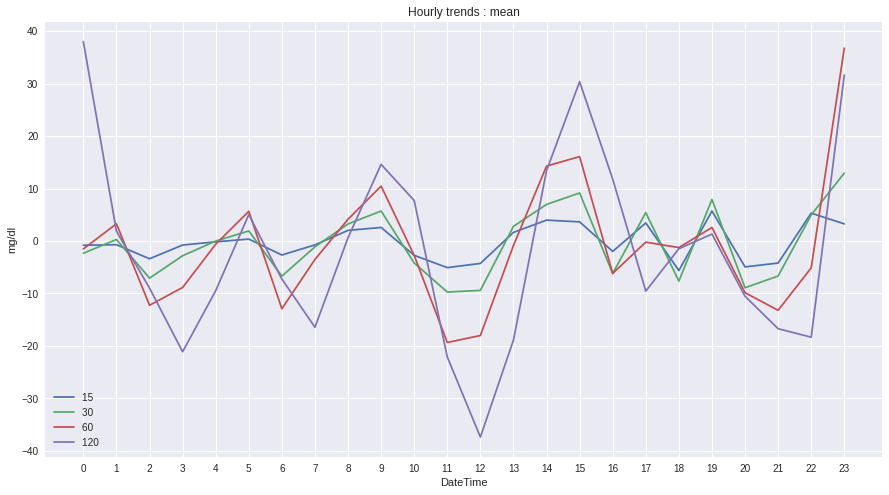

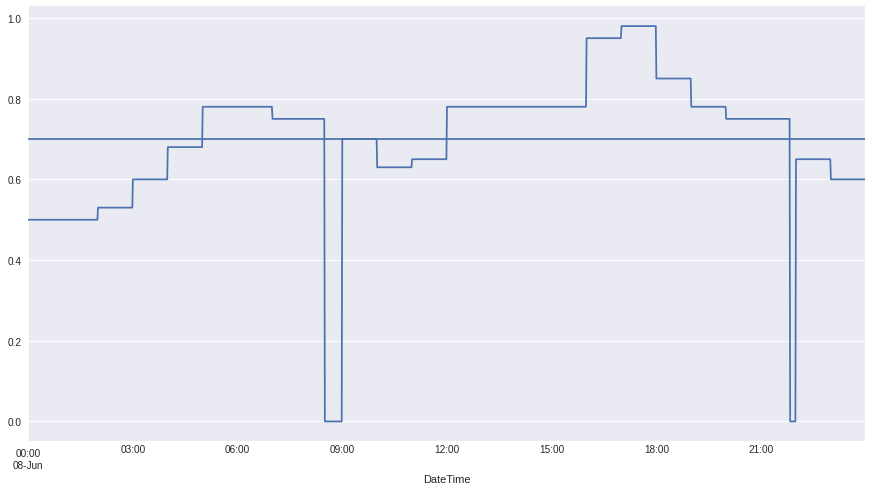

In [224]:
hourly_trends(latest, kind="mean")
plt.figure()
debasal = latest.loc[str(dates[-2]),"Basal Rate (U/h)"]
debasal.plot()
plt.axhline(debasal.mean())

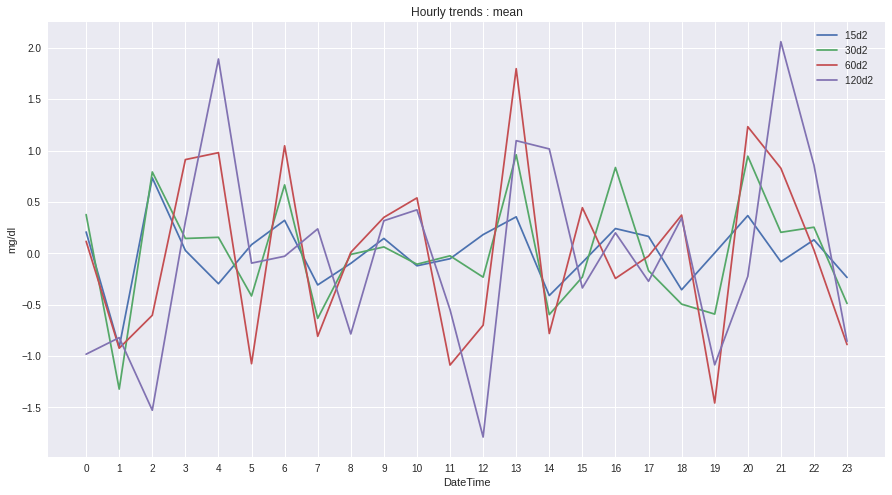

In [36]:
hourly_trends(latest, kind="mean", deltas=["15d2", "30d2", "60d2", "120d2"])

In [89]:
latest["Basal Rate (U/h)"].describe()

count    4321.000000
mean        0.710278
std         0.192548
min         0.000000
25%         0.630000
50%         0.750000
75%         0.780000
max         1.310000
Name: Basal Rate (U/h), dtype: float64

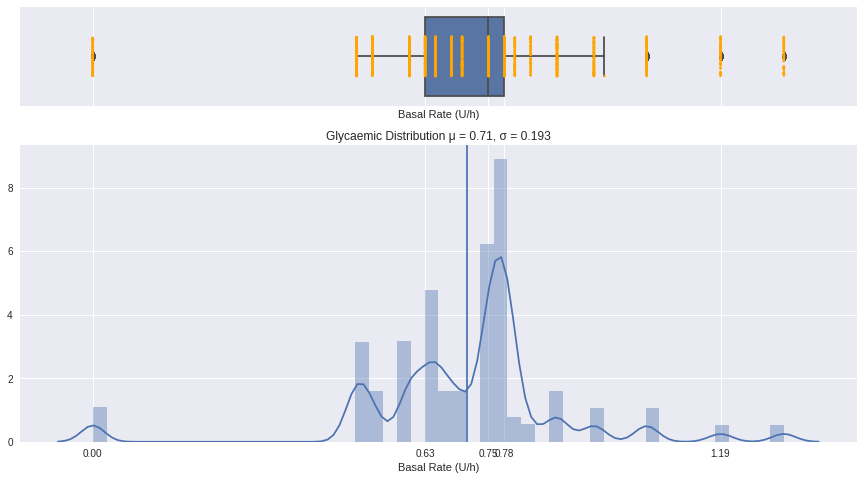

In [94]:
dist_plot(latest["Basal Rate (U/h)"], sig=3)

In [40]:
#hourly_trends(basal, kind="std")

In [79]:
basal = basal_only(latest)

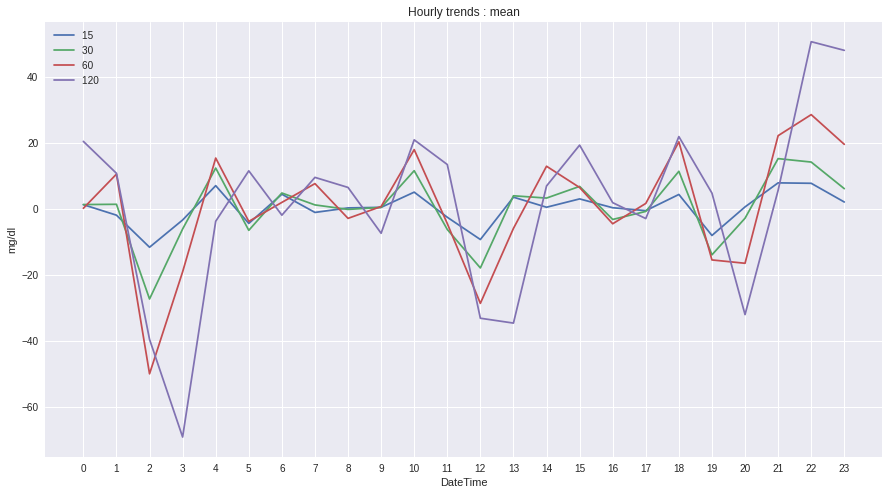

In [80]:
hourly_trends(basal)

In [81]:
#hourly_trends(basal, kind="std")

In [82]:
bar = nonull_indices(latest, "BWZ Carb Input (grams)")

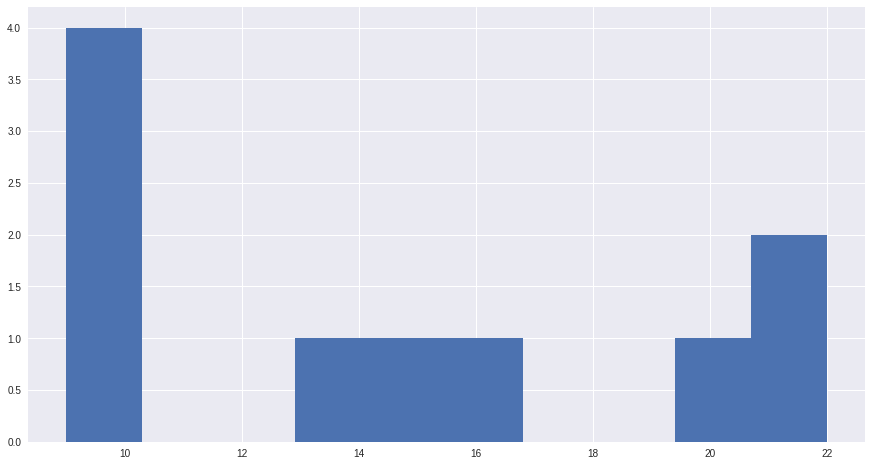

In [83]:
bar.hour.to_series().hist()

In [84]:
foo = nonull_indices(latest, "BWZ Correction Estimate (U)")

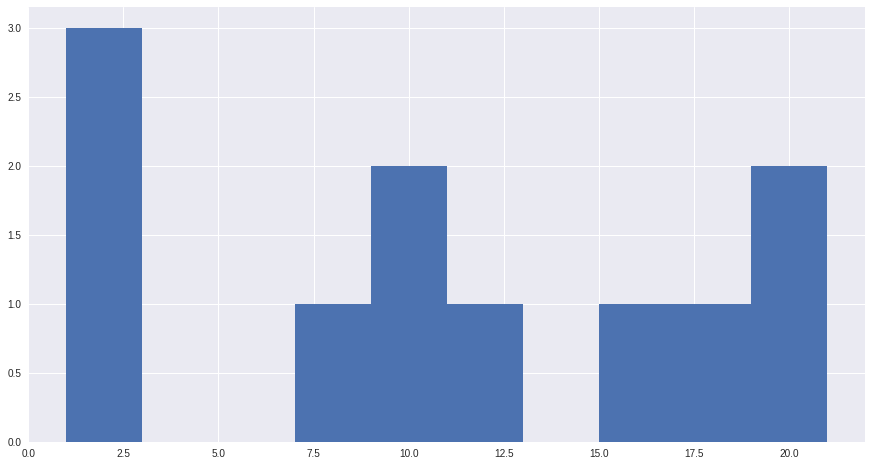

In [85]:
foo.hour.to_series().hist()